In [1]:
import os
import seaborn as sns
import cv2
import torch
import timm
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.utils.data import DataLoader, Dataset,Subset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = r"C:\Users\Minoo\Desktop\veronesi"

In [4]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'male': 0, 'female': 1}
    )
    return generator


data_generator = generate_data(data_dir)


total_image = np.concatenate([data_generator.labels])

print('\n\n',{'male':len(np.where(total_image==0)[0]),
      'female':len(np.where(total_image==1)[0])})

Found 336 images belonging to 2 classes.


 {'male': 139, 'female': 197}


In [6]:
import math

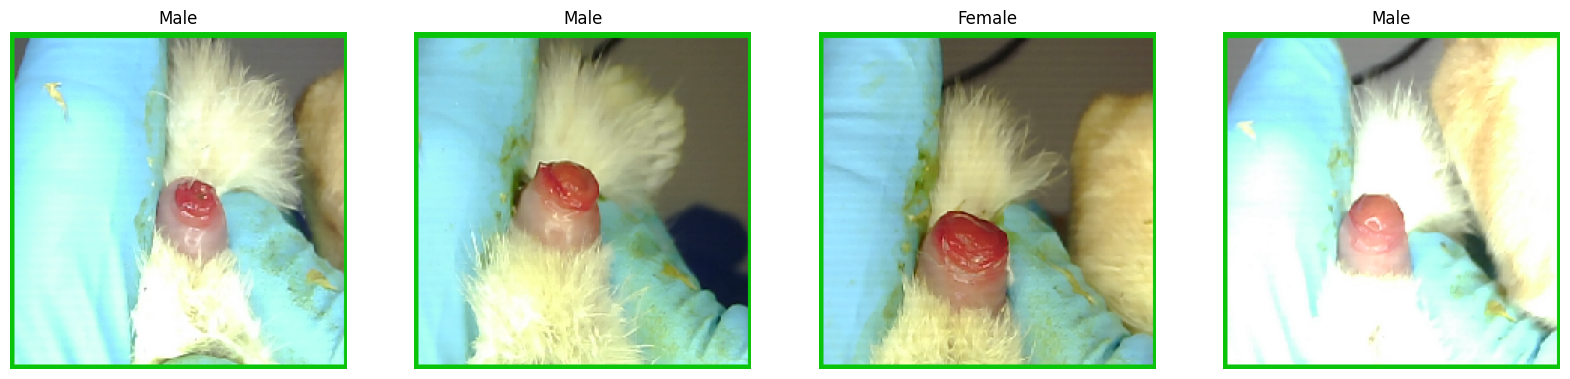

In [8]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Male" if img_label[i] == 0 else "Female" )
        plt.axis("off")

image_plot(data_generator,4)

preparing data

In [14]:
import os
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from collections import Counter

class BalancedDataset(Dataset):
    """Balanced dataset with augmentation for minority classes"""
    def __init__(self, dataset, indices, balance_to=None, transform=None):
        self.dataset = dataset
        self.transform = transform
        
        # Group samples by class
        class_samples = {}
        for idx in indices:
            _, label = dataset[idx]
            if label not in class_samples:
                class_samples[label] = []
            class_samples[label].append(idx)
        
        # Balance classes
        if balance_to is None:
            balance_to = max(len(samples) for samples in class_samples.values())
        
        self.samples = []
        for label, samples in class_samples.items():
            # Add original samples
            self.samples.extend([(idx, label) for idx in samples])
            
            # Augment if needed
            if len(samples) < balance_to:
                needed = balance_to - len(samples)
                augmented = [random.choice(samples) for _ in range(needed)]
                self.samples.extend([(idx, label) for idx in augmented])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        original_idx, label = self.samples[idx]
        img, _ = self.dataset[original_idx]
        if self.transform:
            img = self.transform(img)
        return img, label

def create_transforms():
    """Create train/val/test transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def prepare_data(data_dir, batch_size=32, train_ratio=0.7, val_ratio=0.15):
    """Main data preparation function"""
    
    # Load dataset and analyze
    dataset = datasets.ImageFolder(data_dir)
    print(f"Total samples: {len(dataset)}")
    print(f"Classes: {dataset.classes}")
    
    # Count samples per class
    labels = [dataset[i][1] for i in range(len(dataset))]
    class_counts = Counter(labels)
    print("Original distribution:")
    for i, class_name in enumerate(dataset.classes):
        print(f"  {class_name}: {class_counts[i]}")
    
    # Split dataset
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size
    
    train_indices, val_indices, test_indices = random_split(
        range(total_size), [train_size, val_size, test_size]
    )
    
    # Create transforms
    train_transform, val_transform = create_transforms()
    
    # Create balanced datasets
    train_dataset = BalancedDataset(dataset, train_indices, transform=train_transform)
    val_dataset = BalancedDataset(dataset, val_indices, transform=val_transform)
    
    # Test dataset (no balancing)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    test_dataset.dataset.transform = val_transform
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\nFinal sizes:")
    print(f"  Train: {len(train_dataset)}")
    print(f"  Val: {len(val_dataset)}")
    print(f"  Test: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

# Usage
if __name__ == "__main__":
    data_dir = r"C:\Users\Minoo\Desktop\veronesi"
    train_loader, val_loader, test_loader = prepare_data(data_dir)
    
    # Ready for training!
    print("✅ Data preparation complete!")

Total samples: 336
Classes: ['female', 'male']
Original distribution:
  female: 197
  male: 139

Final sizes:
  Train: 274
  Val: 60
  Test: 51
✅ Data preparation complete!


In [25]:
import os
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset

class BalancedAugmentedDataset(Dataset):
    def __init__(self, original_dataset, indices, target_count=1000, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform
        self.target_count = target_count

        # Group images by class
        self.class_images = {}
        for idx in indices:
            img_path, class_idx = original_dataset.samples[idx]
            if class_idx not in self.class_images:
                self.class_images[class_idx] = []
            self.class_images[class_idx].append(img_path)

        # Create balanced dataset
        self.samples = []
        for class_idx, images in self.class_images.items():
            original_count = len(images)
            if original_count >= target_count:
                self.samples.extend([(img, class_idx) for img in images[:target_count]])
            else:
                self.samples.extend([(img, class_idx) for img in images])
                augment_count = target_count - original_count
                self.samples.extend([(random.choice(images), class_idx) for _ in range(augment_count)])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        img = self.original_dataset.loader(img_path)
        if self.transform:
            img = self.transform(img)
        return img, class_idx

# Data Loading and Preprocessing
data_dir = r"C:\Users\Minoo\Desktop\veronesi"
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
target_count_per_class = 310
val_target_count_per_class = 43  # Target count per class for validation

def gaussian_blur(image):
    return transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))(image)

class RandomApply(object):
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.transform(img)
        return img

# Define transformations for training (including augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomApply(gaussian_blur, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for validation with mild augmentation
val_augment_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Define transformations for validation and testing (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir)

# Calculate dataset sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split dataset indices
train_indices, val_indices, test_indices = random_split(range(total_size), [train_size, val_size, test_size])

# Create the train dataset
train_dataset = BalancedAugmentedDataset(full_dataset, train_indices, target_count_per_class, train_transform)

# Create the validation dataset with augmentation to reach target size
val_dataset = BalancedAugmentedDataset(full_dataset, val_indices, val_target_count_per_class, val_augment_transform)

# Create test dataset without augmentation
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)
test_dataset.dataset.transform = val_test_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples (with augmentation): {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 620
Validation samples (with augmentation): 86
Test samples: 51


vgg16

c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 0.6847, Validation Loss: 0.6834, Validation Accuracy: 0.5814
Epoch 2/50, Training Loss: 0.6098, Validation Loss: 0.7539, Validation Accuracy: 0.6279
Epoch 3/50, Training Loss: 0.4911, Validation Loss: 1.2605, Validation Accuracy: 0.5465
Epoch 4/50, Training Loss: 0.3124, Validation Loss: 0.8376, Validation Accuracy: 0.6977
Epoch 5/50, Training Loss: 0.2337, Validation Loss: 1.0436, Validation Accuracy: 0.7209
Epoch 6/50, Training Loss: 0.1791, Validation Loss: 0.9818, Validation Accuracy: 0.6279
Epoch 7/50, Training Loss: 0.0789, Validation Loss: 1.4839, Validation Accuracy: 0.6628
Epoch 8/50, Training Loss: 0.0423, Validation Loss: 1.4559, Validation Accuracy: 0.7093
Epoch 9/50, Training Loss: 0.0474, Validation Loss: 1.0756, Validation Accuracy: 0.7209
Epoch 10/50, Training Loss: 0.0269, Validation Loss: 1.3279, Validation Accuracy: 0.7326
Epoch 11/50, Training Loss: 0.0114, Validation Loss: 1.3927, Validation Accuracy: 0.6744
Epoch 12/50, Training Loss: 0.

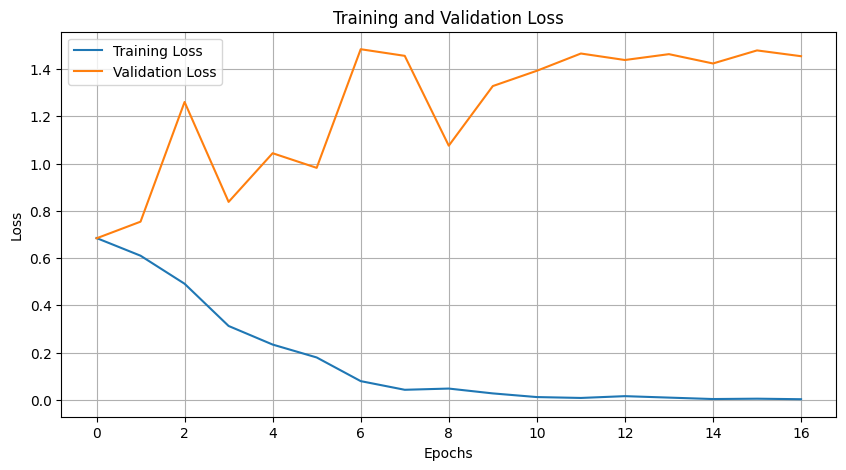

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\1395885617.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg16_model.pth'))
Evaluat

Test Accuracy: 60.78%


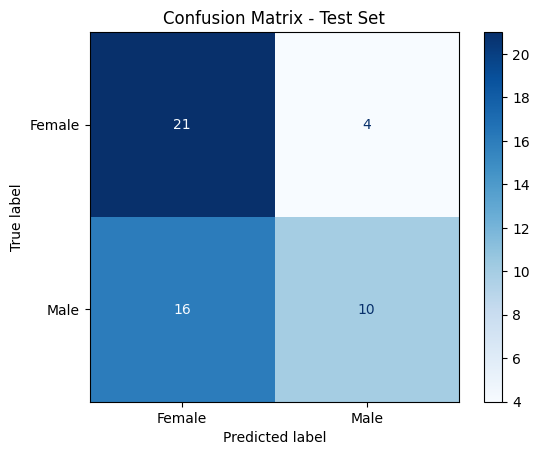

              precision    recall  f1-score   support

      Female       0.57      0.84      0.68        25
        Male       0.71      0.38      0.50        26

    accuracy                           0.61        51
   macro avg       0.64      0.61      0.59        51
weighted avg       0.64      0.61      0.59        51



In [26]:

# Define the VGG16 model architecture
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Modify for 2 classes: male and female
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # No class weights needed for balanced classes
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping setup
best_val_acc = 0
patience = 7
epochs_no_improve = 0

# Lists to store losses
train_losses, val_losses = [], []

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate average validation loss and accuracy
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping conditions
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'vgg16_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

print(f'Training completed. Best Validation Accuracy: {best_val_acc:.2f}%')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model for further evaluation
model.load_state_dict(torch.load('vgg16_model.pth'))

# Evaluate the model on the test set
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating on test set"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_preds, all_labels

# Load the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
class_names = ['Female', 'Male']  # Update with your actual class names
test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, device, class_names)

# Display the confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for more insights
print(classification_report(test_labels, test_preds, target_names=class_names))

c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\3652221193.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

VGG16 Feature Layers:
  0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  1: ReLU(inplace=True)
  2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  3: ReLU(inplace=True)
  4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  6: ReLU(inplace=True)
  7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8: ReLU(inplace=True)
  9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  11: ReLU(inplace=True)
  12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  13: ReLU(inplace=True)
  14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  15: ReLU(inplace=True)
  16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  17: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), 

Computing accuracy: 100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Test Accuracy: 60.78%


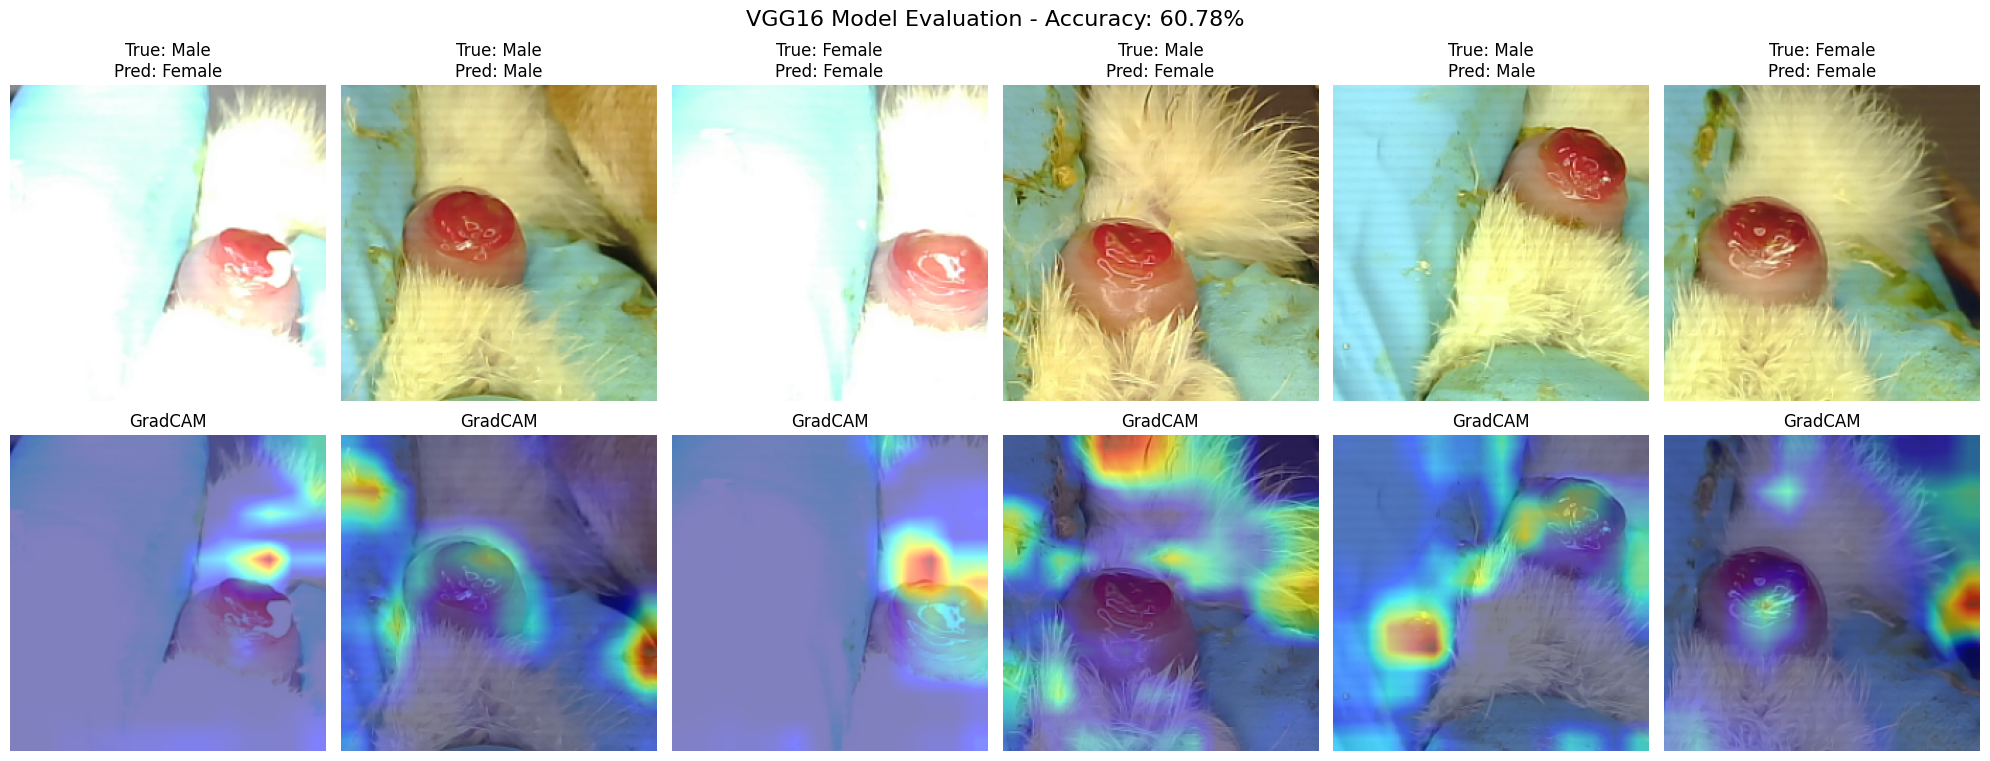

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the VGG16 model architecture
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Modify for 2 classes: male and female

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('vgg16_model.pth', map_location=device))
model = model.to(device)

# Define the get_gradcam function for VGG16
def get_gradcam(model, input_image, target_class, target_layer='features.29'):  # VGG16's last conv layer
    model.eval()
    
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Find the target layer
    for name, module in model.named_modules():
        if name == target_layer:
            forward_hook_handle = module.register_forward_hook(forward_hook)
            backward_hook_handle = module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Could not find target layer: {target_layer}")

    try:
        output = model(input_image)
        
        if not activations:
            raise ValueError("Forward hook was not called")
        
        model.zero_grad()
        loss = output[0, target_class]
        loss.backward()
        
        if not gradients:
            raise ValueError("Backward hook was not called")

        gradients = gradients[0]
        activations = activations[0]

        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

    finally:
        forward_hook_handle.remove()
        backward_hook_handle.remove()

# Define the compute_accuracy function
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Computing accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return 100 * correct / total, all_preds, all_labels

# Define the visualize_gradcam function for VGG16
def visualize_gradcam(model, test_loader, device, num_images=6, target_layer='features.29'):
    model = model.to(device)
    
    # Compute accuracy and get predictions
    accuracy, all_preds, all_labels = compute_accuracy(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Get a batch of images
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images.to(device)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    fig.suptitle(f"VGG16 Model Evaluation - Accuracy: {accuracy:.2f}%", fontsize=16)

    for i in range(num_images):
        sample_image = sample_images[i].unsqueeze(0)
        true_label = sample_labels[i].item()
        predicted_label = model(sample_image).argmax().item()

        # Denormalize image for visualization
        denormalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        denorm_image = denormalize(sample_image[0])
        denorm_image = torch.clamp(denorm_image, 0, 1)

        # Original image
        axes[0, i].imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title(f"True: {'Male' if true_label == 1 else 'Female'}\nPred: {'Male' if predicted_label == 1 else 'Female'}")
        axes[0, i].axis('off')

        # GradCAM
        cam = get_gradcam(model, sample_image, predicted_label, target_layer)
        axes[1, i].imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
        axes[1, i].imshow(cam, cmap='jet', alpha=0.5)
        axes[1, i].set_title("GradCAM")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Print VGG16 architecture to help choose target layer
def print_vgg16_layers(model):
    print("VGG16 Feature Layers:")
    for name, module in model.features.named_modules():
        if name:  # Skip the container itself
            print(f"  {name}: {module}")
    
    print("\nVGG16 Classifier Layers:")
    for name, module in model.classifier.named_modules():
        if name:  # Skip the container itself
            print(f"  {name}: {module}")

# Load the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Print layer information (helpful for choosing target layer)
print_vgg16_layers(model)

# Assume test_dataset is defined and available
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run the visualization with VGG16's last conv layer
visualize_gradcam(model, test_loader, device, target_layer='features.29')

# Alternative target layers for VGG16:
# 'features.28' - Last ReLU layer
# 'features.26' - Second to last conv layer  
# 'features.24' - Third to last conv layer

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\3985456829.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg16_model.pth'))


VGG16 Feature Layers (use these for target_layer):
  0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  1: ReLU(inplace=True)
  2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  3: ReLU(inplace=True)
  4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  6: ReLU(inplace=True)
  7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8: ReLU(inplace=True)
  9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  11: ReLU(inplace=True)
  12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  13: ReLU(inplace=True)
  14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  15: ReLU(inplace=True)
  16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  17: Conv2d(256, 512, kernel

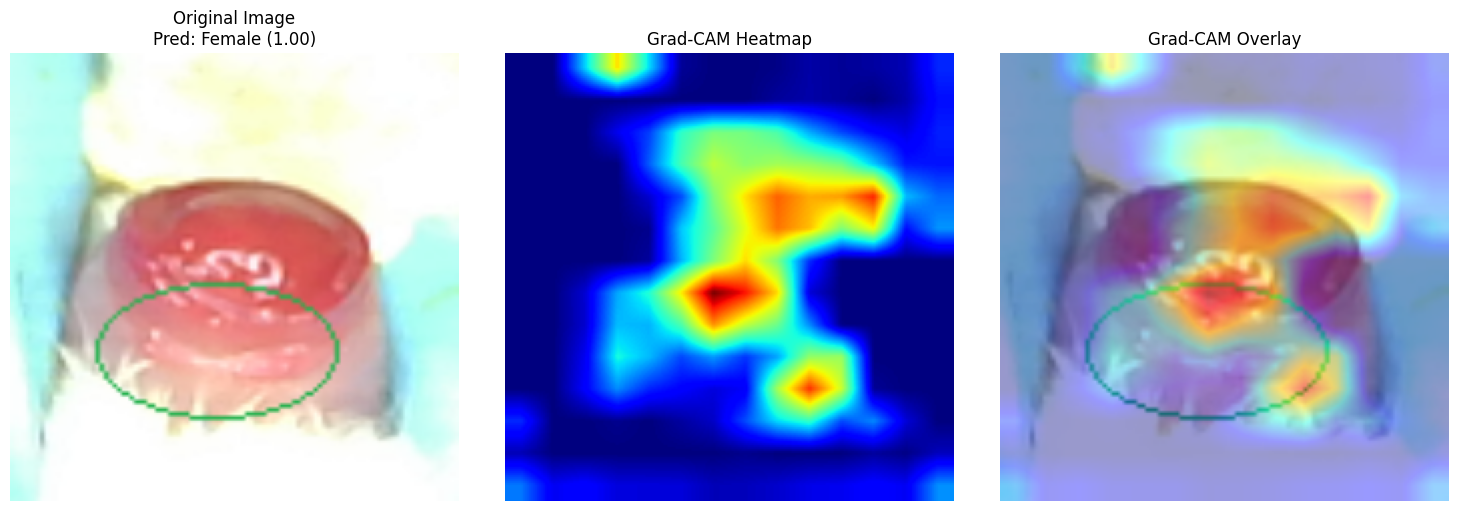

Prediction: Female
Confidence: 0.9987


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Load VGG16 model with pre-trained weights
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Modify for 2 classes: male and female

# Load the trained model weights
model.load_state_dict(torch.load('vgg16_model.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Set device to GPU if available
model.eval()

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to get Grad-CAM for VGG16
def get_gradcam(model, input_image, target_class, target_layer='features.29'):  # VGG16's last conv layer
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Register hooks
    for name, module in model.named_modules():
        if name == target_layer:
            forward_hook_handle = module.register_forward_hook(forward_hook)
            backward_hook_handle = module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Could not find target layer: {target_layer}")

    try:
        # Forward pass
        output = model(input_image)

        # Ensure forward hook was called
        if not activations:
            raise ValueError("Forward hook was not called")

        # Zero the gradients
        model.zero_grad()

        # Backward pass
        loss = output[0, target_class]
        loss.backward()

        # Ensure backward hook was called
        if not gradients:
            raise ValueError("Backward hook was not called")

        # Compute Grad-CAM
        gradients = gradients[0]
        activations = activations[0]

        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize the CAM
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

    finally:
        forward_hook_handle.remove()
        backward_hook_handle.remove()

# Function to visualize predictions with Grad-CAM for VGG16
def visualize_prediction(image_path, model, transform, device, target_layer='features.29'):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][predicted_class].item()

    # Get Grad-CAM heatmap
    cam = get_gradcam(model, input_tensor, predicted_class, target_layer)

    # Prepare the image for visualization
    img_np = np.array(image)
    img_np = cv2.resize(img_np, (224, 224))  # Resize image to match CAM size
    cam = cv2.resize(cam, (224, 224))  # Resize CAM to match image size
    cam = np.uint8(255 * cam)  # Scale CAM to [0, 255] for visualization
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    
    # Convert BGR to RGB for matplotlib
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Display the image with Grad-CAM
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title(f'Original Image\nPred: {"Male" if predicted_class == 1 else "Female"} ({confidence:.2f})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"Prediction: {'Male' if predicted_class == 1 else 'Female'}")
    print(f"Confidence: {confidence:.4f}")

# Function to print VGG16 layers (helpful for choosing target layer)
def print_vgg16_layers():
    print("VGG16 Feature Layers (use these for target_layer):")
    temp_model = models.vgg16()
    for name, module in temp_model.features.named_modules():
        if name and isinstance(module, (nn.Conv2d, nn.ReLU, nn.MaxPool2d)):
            print(f"  {name}: {module}")
    
    print("\nRecommended target layers for GradCAM:")
    print("  'features.29' - Last conv layer (best choice)")
    print("  'features.26' - Second to last conv layer")
    print("  'features.23' - Third to last conv layer")

# Print available layers
print_vgg16_layers()

# Example usage:
# Specify your image path here
image_path = r"C:\Users\Minoo\Desktop\male_302.png"  # Update with your image path
visualize_prediction(image_path, model, transform, 'cuda' if torch.cuda.is_available() else 'cpu')

# You can also try different target layers:
# visualize_prediction(image_path, model, transform, device, target_layer='features.26')
# visualize_prediction(image_path, model, transform, device, target_layer='features.23')

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\3646914640.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg16_model.pth'))


VGG16 Feature Layers (use these for target_layer):
  0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  1: ReLU(inplace=True)
  2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  3: ReLU(inplace=True)
  4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  6: ReLU(inplace=True)
  7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8: ReLU(inplace=True)
  9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  11: ReLU(inplace=True)
  12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  13: ReLU(inplace=True)
  14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  15: ReLU(inplace=True)
  16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  17: Conv2d(256, 512, kernel

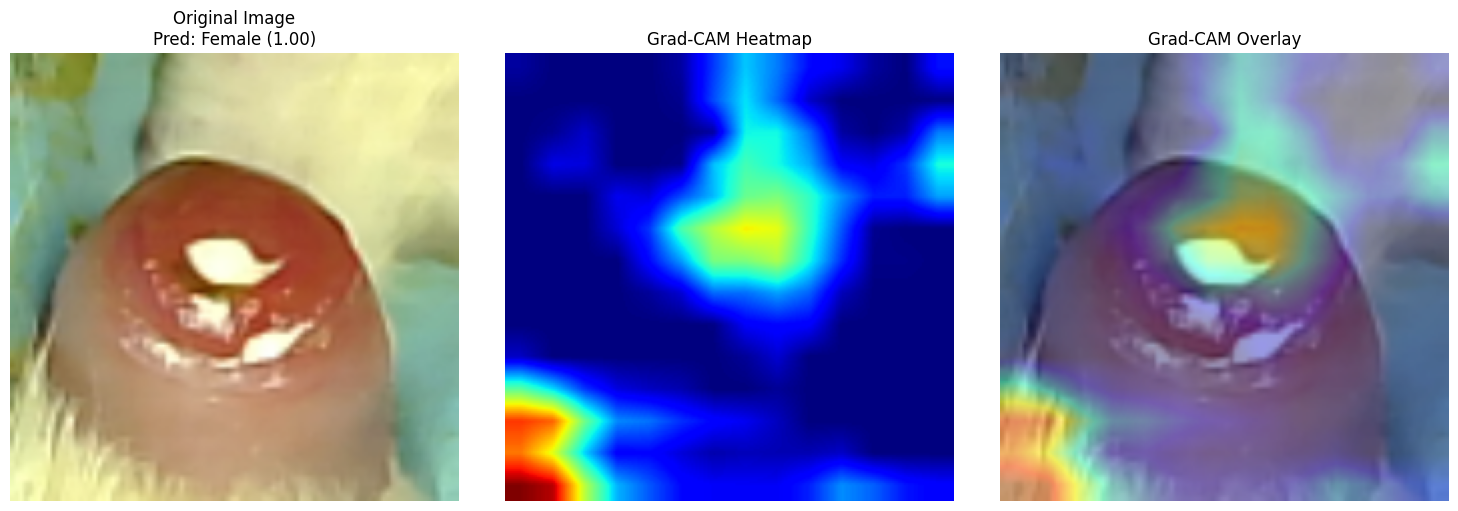

Prediction: Female
Confidence: 0.9983


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Load VGG16 model with pre-trained weights
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Modify for 2 classes: male and female

# Load the trained model weights
model.load_state_dict(torch.load('vgg16_model.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Set device to GPU if available
model.eval()

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to get Grad-CAM for VGG16
def get_gradcam(model, input_image, target_class, target_layer='features.29'):  # VGG16's last conv layer
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Register hooks
    for name, module in model.named_modules():
        if name == target_layer:
            forward_hook_handle = module.register_forward_hook(forward_hook)
            backward_hook_handle = module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Could not find target layer: {target_layer}")

    try:
        # Forward pass
        output = model(input_image)

        # Ensure forward hook was called
        if not activations:
            raise ValueError("Forward hook was not called")

        # Zero the gradients
        model.zero_grad()

        # Backward pass
        loss = output[0, target_class]
        loss.backward()

        # Ensure backward hook was called
        if not gradients:
            raise ValueError("Backward hook was not called")

        # Compute Grad-CAM
        gradients = gradients[0]
        activations = activations[0]

        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize the CAM
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

    finally:
        forward_hook_handle.remove()
        backward_hook_handle.remove()

# Function to visualize predictions with Grad-CAM for VGG16
def visualize_prediction(image_path, model, transform, device, target_layer='features.29'):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][predicted_class].item()

    # Get Grad-CAM heatmap
    cam = get_gradcam(model, input_tensor, predicted_class, target_layer)

    # Prepare the image for visualization
    img_np = np.array(image)
    img_np = cv2.resize(img_np, (224, 224))  # Resize image to match CAM size
    cam = cv2.resize(cam, (224, 224))  # Resize CAM to match image size
    cam = np.uint8(255 * cam)  # Scale CAM to [0, 255] for visualization
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    
    # Convert BGR to RGB for matplotlib
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Display the image with Grad-CAM
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title(f'Original Image\nPred: {"Male" if predicted_class == 1 else "Female"} ({confidence:.2f})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"Prediction: {'Male' if predicted_class == 1 else 'Female'}")
    print(f"Confidence: {confidence:.4f}")

# Function to print VGG16 layers (helpful for choosing target layer)
def print_vgg16_layers():
    print("VGG16 Feature Layers (use these for target_layer):")
    temp_model = models.vgg16()
    for name, module in temp_model.features.named_modules():
        if name and isinstance(module, (nn.Conv2d, nn.ReLU, nn.MaxPool2d)):
            print(f"  {name}: {module}")
    
    print("\nRecommended target layers for GradCAM:")
    print("  'features.29' - Last conv layer (best choice)")
    print("  'features.26' - Second to last conv layer")
    print("  'features.23' - Third to last conv layer")

# Print available layers
print_vgg16_layers()

# Example usage:
# Specify your image path here
image_path = r"C:\Users\Minoo\Desktop\female_242.png"  # Update with your image path
visualize_prediction(image_path, model, transform, 'cuda' if torch.cuda.is_available() else 'cpu')

# You can also try different target layers:
# visualize_prediction(image_path, model, transform, device, target_layer='features.26')
# visualize_prediction(image_path, model, transform, device, target_layer='features.23')

c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Minoo/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 35.4MB/s]
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-pack

Epoch 1/50, Training Loss: 0.7057306230068207, Validation Loss: 0.7109035849571228, Validation Accuracy: 0.45348837209302323
Epoch 2/50, Training Loss: 0.6297227501869201, Validation Loss: 0.65910271803538, Validation Accuracy: 0.6046511627906976
Epoch 3/50, Training Loss: 0.5812678456306457, Validation Loss: 0.6594490011533102, Validation Accuracy: 0.5813953488372093
Epoch 4/50, Training Loss: 0.5146026715636254, Validation Loss: 0.6593429247538248, Validation Accuracy: 0.5232558139534884
Epoch 5/50, Training Loss: 0.4465460881590843, Validation Loss: 0.6402813394864401, Validation Accuracy: 0.5930232558139535
Epoch 6/50, Training Loss: 0.38168177753686905, Validation Loss: 0.6767691473166147, Validation Accuracy: 0.627906976744186
Epoch 7/50, Training Loss: 0.29544286504387857, Validation Loss: 0.7152752776940664, Validation Accuracy: 0.6627906976744186
Epoch 8/50, Training Loss: 0.18793589919805526, Validation Loss: 0.6770076950391134, Validation Accuracy: 0.6627906976744186
Epoch 9

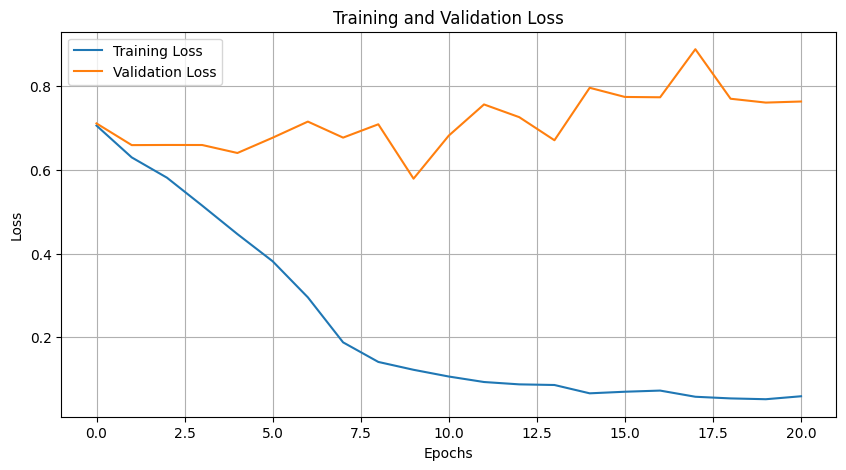

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\1551549948.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_model.pth'))

Test Accuracy: 72.55%


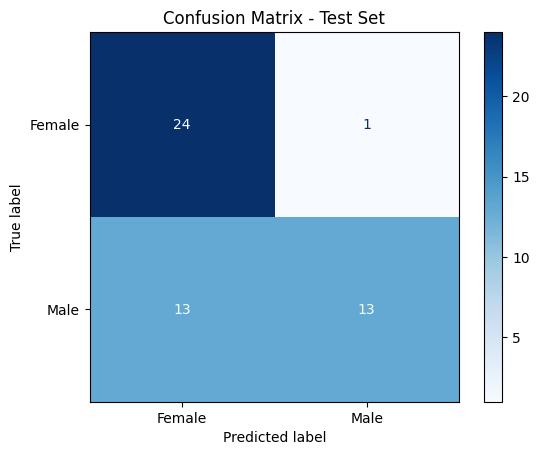

              precision    recall  f1-score   support

      Female       0.65      0.96      0.77        25
        Male       0.93      0.50      0.65        26

    accuracy                           0.73        51
   macro avg       0.79      0.73      0.71        51
weighted avg       0.79      0.73      0.71        51



In [27]:
# Define the EfficientNet-B0 model architecture
model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.7),  # Add dropout for regularization
    nn.Linear(model.classifier[1].in_features, 2)  # Modify for 2 classes: male and female
)
model = model.to(device)

# Define a weighted loss function to handle class imbalance
class_weights = torch.tensor([1.0, 1.0]).to(device)  # Adjust weights as necessary based on your class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping setup
best_val_acc = 0
patience = 7
epochs_no_improve = 0
early_stop = False

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_acc}")

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Check early stopping conditions
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'efficientnet_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            early_stop = True
            break

print('Training completed. Best Validation Accuracy: {:.2f}%'.format(best_val_acc * 100))

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model for further evaluation or use
model.load_state_dict(torch.load('efficientnet_model.pth'))

# Evaluate the model on the test set
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating on test set"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_preds, all_labels

# Load the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set using the test_loader
class_names = ['Female', 'Male']  # Update with your actual class names
test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, device, class_names)

# Display the confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for more insights
print(classification_report(test_labels, test_preds, target_names=class_names))

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\2129951922.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_model.pth', m

Test Accuracy: 72.55%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5527872..2.64].
c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5527872..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.535425

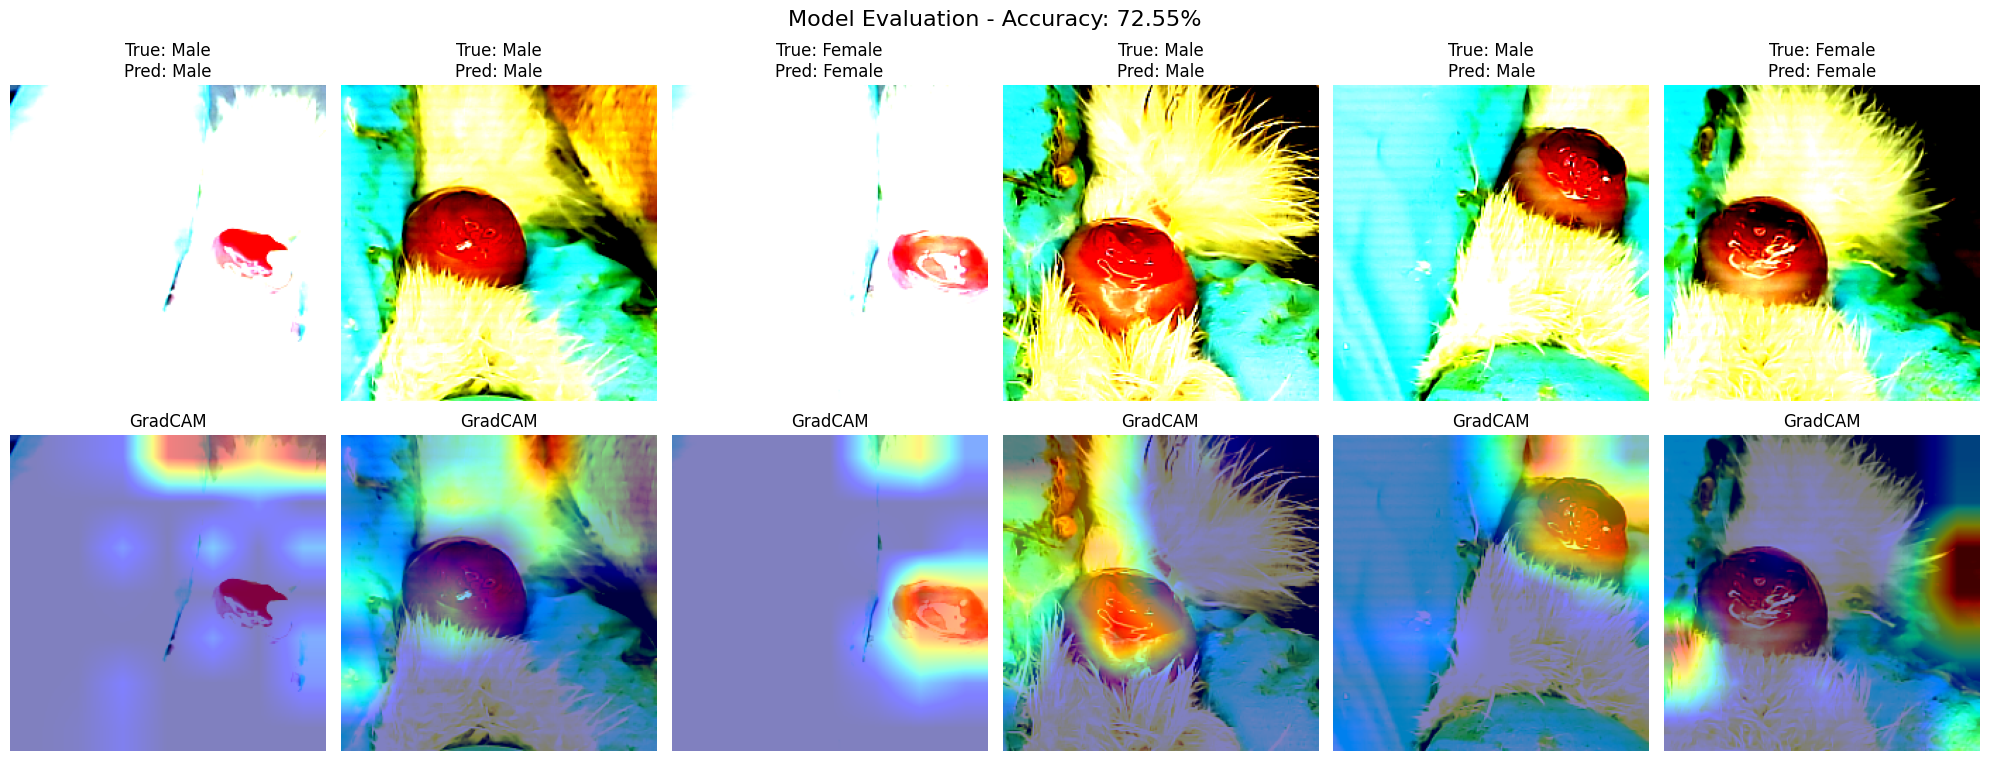

In [30]:

# Define the EfficientNet-B0 model architecture
model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.7),  # Add dropout for regularization
    nn.Linear(model.classifier[1].in_features, 2)  # Modify for 2 classes: male and female
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('efficientnet_model.pth', map_location=device))
model = model.to(device)

# Define the get_gradcam function
def get_gradcam(model, input_image, target_class, target_layer='features.6'):  # Adjusted target layer
    model.eval()
    
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Find the target layer
    for name, module in model.named_modules():
        if name == target_layer:
            forward_hook_handle = module.register_forward_hook(forward_hook)
            backward_hook_handle = module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Could not find target layer: {target_layer}")

    try:
        output = model(input_image)
        
        if not activations:
            raise ValueError("Forward hook was not called")
        
        model.zero_grad()
        loss = output[0, target_class]
        loss.backward()
        
        if not gradients:
            raise ValueError("Backward hook was not called")

        gradients = gradients[0]
        activations = activations[0]

        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

    finally:
        forward_hook_handle.remove()
        backward_hook_handle.remove()

# Define the compute_accuracy function
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Computing accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return 100 * correct / total, all_preds, all_labels

# Define the visualize_gradcam function
def visualize_gradcam(model, test_loader, device, num_images=6, target_layer='features.6'):  # Corrected target layer
    model = model.to(device)
    
    # Compute accuracy and get predictions
    accuracy, all_preds, all_labels = compute_accuracy(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Get a batch of images
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images.to(device)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    fig.suptitle(f"Model Evaluation - Accuracy: {accuracy:.2f}%", fontsize=16)

    for i in range(num_images):
        sample_image = sample_images[i].unsqueeze(0)
        true_label = sample_labels[i].item()
        predicted_label = model(sample_image).argmax().item()

        # Original image
        axes[0, i].imshow(sample_image[0].permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title(f"True: {'Male' if true_label == 1 else 'Female'}\nPred: {'Male' if predicted_label == 1 else 'Female'}")
        axes[0, i].axis('off')

        # GradCAM
        cam = get_gradcam(model, sample_image, predicted_label, target_layer)
        axes[1, i].imshow(sample_image[0].permute(1, 2, 0).cpu().numpy())
        axes[1, i].imshow(cam, cmap='jet', alpha=0.5)
        axes[1, i].set_title("GradCAM")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Load the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assume test_dataset is defined and available
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run the visualization
visualize_gradcam(model, test_loader, device, target_layer='features.6')

C:\Users\Minoo\AppData\Local\Temp\ipykernel_6032\324950242.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_model.pth'))
c:

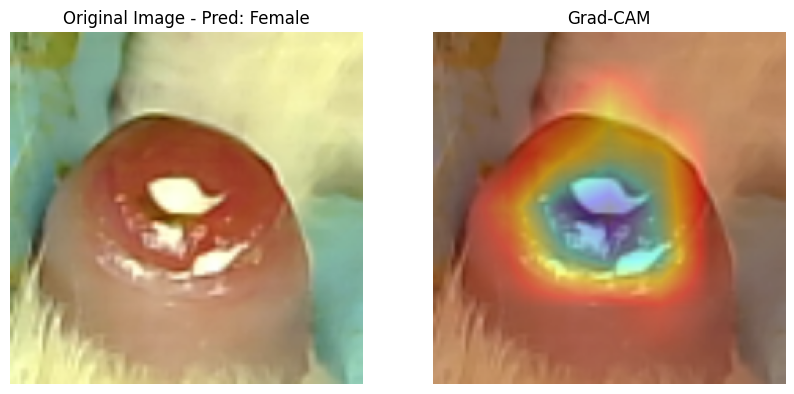

In [33]:
# Load EfficientNet model with pre-trained weights
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.6),  # Add dropout for regularization
    nn.Linear(model.classifier[1].in_features, 2)  # Modify for 2 classes: male and female
)

# Load the trained model weights
model.load_state_dict(torch.load('efficientnet_model.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Set device to GPU if available
model.eval()

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to get Grad-CAM
def get_gradcam(model, input_image, target_class, target_layer='features.6'):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Register hooks
    for name, module in model.named_modules():
        if name == target_layer:
            forward_hook_handle = module.register_forward_hook(forward_hook)
            backward_hook_handle = module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Could not find target layer: {target_layer}")

    try:
        # Forward pass
        output = model(input_image)

        # Ensure forward hook was called
        if not activations:
            raise ValueError("Forward hook was not called")

        # Zero the gradients
        model.zero_grad()

        # Backward pass
        loss = output[0, target_class]
        loss.backward()

        # Ensure backward hook was called
        if not gradients:
            raise ValueError("Backward hook was not called")

        # Compute Grad-CAM
        gradients = gradients[0]
        activations = activations[0]

        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize the CAM
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

    finally:
        forward_hook_handle.remove()
        backward_hook_handle.remove()

# Function to visualize predictions with Grad-CAM
def visualize_prediction(image_path, model, transform, device, target_layer='features.6'):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    # Get Grad-CAM heatmap
    cam = get_gradcam(model, input_tensor, predicted_class, target_layer)

    # Prepare the image for visualization
    img_np = np.array(image)
    img_np = cv2.resize(img_np, (224, 224))  # Resize image to match CAM size
    cam = cv2.resize(cam, (224, 224))  # Resize CAM to match image size
    cam = np.uint8(255 * cam)  # Scale CAM to [0, 255] for visualization
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Display the image with Grad-CAM
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f'Original Image - Pred: {"Male" if predicted_class == 1 else "Female"}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()

# Example usage:
# Specify your image path here
image_path = r"C:\Users\Minoo\Desktop\female_242.png"  # Update with your image path
visualize_prediction(image_path, model, transform, 'cuda' if torch.cuda.is_available() else 'cpu')